c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['input_layer']]. Received: the structure of inputs=*
  warnings.warn(


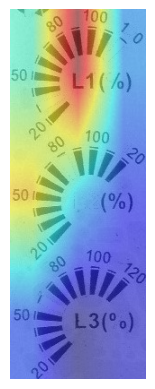

In [2]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the trained CNN model
model = tf.keras.models.load_model("./Custom Model/analog_pretrain.h5")

# Function to generate Grad-CAM heatmap
def generate_grad_cam(model, image, last_conv_layer_name="conv_layer_name", class_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Preprocess the image
    image = cv2.resize(image, (224, 224)) / 255.0
    image = np.expand_dims(image, axis=0)

    # Forward pass through the model
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        if class_index is None:
            class_index = np.argmax(predictions[0])
        loss = predictions[:, class_index]

    # Compute gradients of the top class prediction
    grads = tape.gradient(loss, conv_outputs)

    # Take the mean of the gradients along the depth
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by its corresponding gradient
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0) / tf.reduce_max(heatmap)

    return heatmap.numpy()

# Load a captured image
captured_image = cv2.imread("./Analog/train/class 0/bad_2.png")

# Generate Grad-CAM heatmap
heatmap = generate_grad_cam(model, captured_image, last_conv_layer_name="conv2d_1")  # Replace with your CNN's last conv layer

# Visualize the heatmap on the original image
def overlay_heatmap(image, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), colormap)
    overlayed_image = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)
    return overlayed_image

# Overlay the heatmap onto the original image
highlighted_image = overlay_heatmap(captured_image, heatmap)
cv2.imwrite("highlighted_image.jpg", highlighted_image)
plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


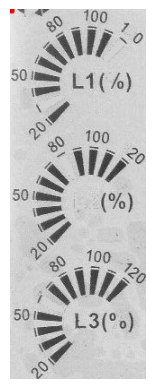

In [3]:
def extract_faulty_segments(heatmap, threshold=0.5):
    # Threshold the heatmap
    binary_map = (heatmap > threshold).astype(np.uint8)

    # Find contours of the high-activation regions
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return contours

# Extract faulty segments
contours = extract_faulty_segments(heatmap, threshold=0.1)

# Draw contours on the original image
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(captured_image, (x, y), (x + w, y + h), (0, 0, 255), 2)

# Save and visualize the result
cv2.imwrite("faulty_segments.jpg", captured_image)
plt.imshow(cv2.cvtColor(captured_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()